In [9]:
# Import packages for calculation and plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter, AutoMinorLocator
# Pandas for convenient table export
import pandas as pd

## Brake system information

- Type TB: Tread Brake
- $p_C$: Brake cylinder pressure [Pa]
- $A_C$: Brake cylinder area [cm$^2$]
- $i_C$: Cylinder transmission ratio [1]
- $\eta_C$: Cylinder efficiency [1]
- $F_{s,C}$: Return spring force [N]
- $i_{rig}$: Brake rigging transmission rate before slack adjuster [1]
- $l_a$: Lever a (cylinder - pivot) [m]
- $l_b$: Lever b (pivot - interface) [m]
- $i_{R}$: Total transmission ratio after slack adjuster [1]
- $\eta_{R}$: Brake rigging efficiency [1]
- $F_{S,R}$: Brake rigging return spring force [N]
- $i_{rig,ax}$: Brake rigging transmission rate at wheel [1]
- $l_{a,ax}$: Lever a (cylinder - pivot) [m]
- $l_{b, ax}$: Lever b (pivot - interface) [m]
- $\mu_m$: Average brake pad or block friction coefficient [1]
- $n_{ax}$: Number of braked wheelsets
- $n_{ap}$: Number of force entry points
- $t_a$: Delay time of cylinder pressure [s]
- $t_{ab}$: Rise time of cylinder pressure [s]
- $m_{st}$: Operating mass vehicle ready for service (per axle) [kg]
- $m_{rot}$: Rotating mass (per axle) [kg]



![Wagon arrangement](TBTransmission.png)

## Brake system parameters

In [106]:
pC = 3.8e5
AC = 0.1295 
iC = 1  
etaC = .98 
FsC = -1500
la = 0.515
lb =0.325
irig = la/lb
nax = 4
nap = 2
laax = 0.5
lbax = 0.5
irigax = laax/lbax
iR = nax*nap*irigax
etaR = 0.83
FSR = -2000 
mum = 0.12 
ta = 0.2 
tab = 4
mst = 90000
mrot = 3600

### Calculation of Forces

#### Brake cylinder force

Brake cylinder force is identical for disc and tread brake.

$$
F_C = p_C A_C i_C \eta_C + F_{c,C}
$$

#### Total force on force entry points

$$
F_b = (F_C i_{rig} + F_{S,R})i_R \eta_R
$$
with
$$
i_{rig} = \frac{l_a}{l_b}
$$
and
$$
i_R = n_{ax} n_{ap} i_{rig,ax} = n_{ax} n_{ap} \frac{l_{a,ax}}{l_{b,ax}}.
$$
#### Mean total force for tread brake arrangement

$$
\bar{F}_B,C = F_b \mu_m
$$

#### Force on single entry point
$$
F_n = \frac{F_b}{2 n_{ax} n_{ap}}
$$

In [59]:
# Brake cylinder force
FC = pC*AC*iC*etaC + FsC
print(f'Brake cylinder force: {np.round(FC)} N')
# Total force on entry points
Fb = (FC*irig +FSR)*iR*etaR
print(f'Total force on entry points: {np.round(Fb)} N')
# Average total brake force
FB = Fb*mum
print(f'Total brake force: {np.round(FBC)} N')
# Force per force entry point (block)
Fn = Fb/(2*nax*nap)
print(f'Force on one entry pointr: {np.round(Fn)} N')

Brake cylinder force: 46726.0 N
Total force on entry points: 478362.0 N
Total brake force: 133941.0 N
Force on one entry pointr: 29898.0 N


#### Equivalent brake build-up time

\begin{equation}
t_{e,i} = t_a + \frac{t_{ab}}{2}
\end{equation}

In [60]:
# Equivalent brake build-up time
te = ta + 0.5*tab
print(f'Brake buildup time: {np.round(te, 2)} s')

Brake buildup time: 2.2 s


## Stopping distance calculation

Following losely EN 14531, App. D. The present calculcation takes into account rotating masses and a resistance force.

In [61]:
# Initial velocity
v0 = 80/3.6
# Terminal velocity
vfin = 0

### Dynamical mass (train level)

$$
m_{dyn} = \Sigma\left(m_{st} + m_{rot} \right)
$$

In [62]:
mdyn = mst + mrot

### Mean resistance

Ride resistance is calculcated as 

$$
\bar{F}_{Ra} = A + \frac{2}{3} B \frac{v_0^2 + v_0 v_{fin} + v_{fin}^2}{v_0 + v_{fin}} + \frac{1}{2} C \left(v_0^2 + v_{fin}^2\right)
$$

with coefficients $A$, $B$ and $C$ according to Strahl equation.

In [63]:
# Vehicle data, resistance coefficients
A = 1.6e-3*mst*9.81
B = 0
C = 5.7e-3*3.6**2/1e5

FRa = A + 2/3*B*(v0**2 + v0*vfin + vfin**2)/(v0+vfin) + 1/2*C*(v0**2+vfin**2)
print(f'Mean resistance force: {np.round(FRa, 1)} N')

Mean resistance force: 1412.6 N


### Equivalent retardation

$$
a_e = \frac{\Sigma\bar{F}_{B,i} + \Sigma\bar{F}_{ext}}{m_{dyn}}
$$

In [64]:
Fext = - FRa
ae = (FB + Fext)/mdyn
print(f'Equivalent deceleration: {np.round(ae, 2)} m/s/s')

Equivalent deceleration: 0.6 m/s/s


### Stopping distance

$$
s = v_0 t_e + \frac{v_0^2 - v_{fin}^2}{2 a_e}
$$

In [65]:
s = v0*te + (v0**2 - vfin**2)/(2*ae)
print(f'Stopping distance from {np.round(v0)} m/s: {np.round(s, 1)} m')

Stopping distance from 22.0 m/s: 461.7 m


### Required adhesion

$$
\tau_{req} = \frac{\Sigma_{ax} \bar{F}_{B,i} - m_{rot, i} a_e}{m_{st} g}
$$

In [66]:
taureq = (FB - mrot*ae)/(mst*9.81)
print(f'Required adhesion: {np.round(taureq, 2)}')

Required adhesion: 0.06


### Energy and power calculcations

$$
W_{B,i} = F_{B,i} \left(s - v_0 t_e\right)
$$

$$
P_{max,i} = F_{B,i} v_0
$$

In [67]:
WB = FB*(s-v0*te)
Pmax = FB*v0
print(f'Total Energy: {np.round(WB/1e6, 2)} MJ')
print(f'Total Power: {np.round(Pmax/1e3, 2)} kW')

Total Energy: 23.69 MJ
Total Power: 1275.63 kW


### Braked weight ratio

#### Replicate tests

Repeated brake distance measurements for 160 km/h, ...,100 km/h.



In [68]:
v0list = [100, 120]
bsdict = {}
for v0 in v0list:
    v0str = str(v0)
    v0 = v0/3.6 # Convert to m/s
    s = v0*te + (v0**2 - vfin**2)/(2*ae)
    bsdict[v0str] = s

#### Plot braking distances

Into plot according to EN 16834.

(40.0, 240.0)

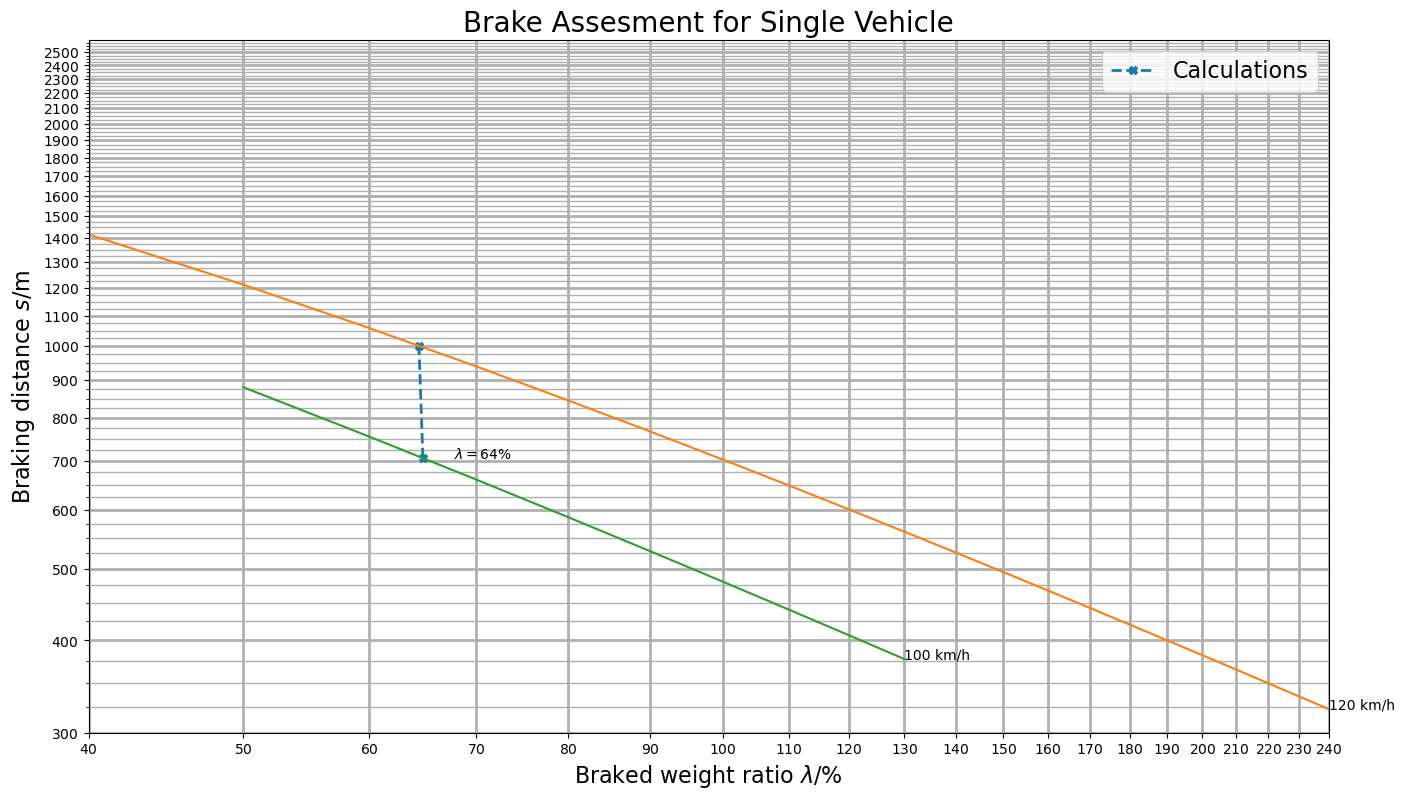

In [69]:
CDdict = {'100': [52840, 10],
'120': [83634, 19]}

# Single vehicles

curvedict = {}
for v in list(CDdict.keys())[1:]:
    l = np.arange(start = 40, stop = 250, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
for v in [100]:
    l = np.arange(start = 50, stop = 140, step = 10)
    params = CDdict[str(v)]
    c = params[0]/(l+params[1])
    curvedict[str(v)] = c
    
# Plotting
fig = plt.figure(figsize = (16, 9))
# Add measurements
bslambda = []
for v in list(CDdict.keys()):
    params = CDdict[str(v)]
    s = bsdict[str(v)]
    bslambda.append(params[0]/s-params[1])
plt.loglog(bslambda, list(bsdict.values()), 'X--', 
           linewidth = 2, label = "Calculations")
plt.annotate('$\lambda = $' + str(int(np.floor(np.min(bslambda)))) + '%', 
             (bslambda[0], list(bsdict.values())[0]),
            verticalalignment = 'top',
            xytext = (bslambda[0]+3, list(bsdict.values())[0]+25))
# Standard curves
for v in list(CDdict.keys())[1:]:
    c = curvedict[str(v)]
    l = np.arange(start = 40, stop = 250, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
for v in [100]:
    c = curvedict[str(v)]
    l = np.arange(start = 50, stop = 140, step = 10)
    plt.loglog(l, c)
    plt.annotate(str(v) + ' km/h', (l[-1],c[-1]))
plt.legend(fontsize = 16)
# Limit axes
plt.ylim(300, 2600)
# Set ticks
plt.gca().set_yticks(ticks=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticklabels(labels=np.arange(300, 2600, 100), minor = False)
plt.gca().set_yticks(ticks=np.arange(300, 2600, 25), minor = True)
plt.gca().set_yticklabels(labels=[], minor = True)
plt.xticks(ticks=np.arange(30, 260, 10), labels=np.arange(300, 2600, 100))
# Set labels
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
# Activate grid
plt.grid(visible = True, which = 'major', linewidth = 2)
plt.grid(visible = True, which = 'minor', linewidth = 1)
# Axis labels
plt.xlabel('Braked weight ratio $\lambda/\%$', fontsize = 16)
plt.ylabel('Braking distance $s/\mathrm{m}$', fontsize = 16)
plt.title('Brake Assesment for Single Vehicle', fontsize = 20)
plt.xlim(40, 240)

## Plot of braked weight over vehicle mass


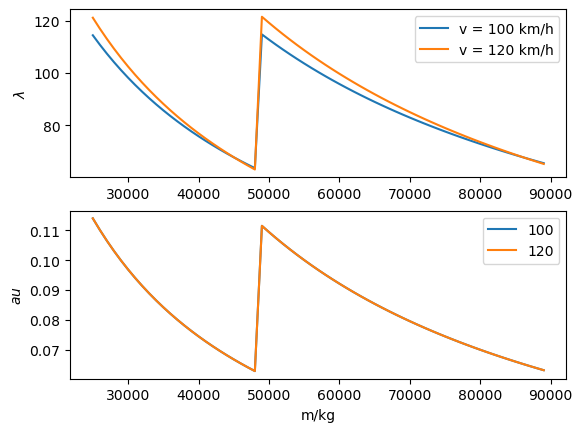

In [116]:
CDdict = {'100': [52840, 10],
'120': [83634, 19]}

pCloaded = 3.8e5
pCempty = 2.2e5
mchangeover = 48000
mrange = np.arange(start = 25000, stop = 90000, step = 1000)
v0list = [100, 120]
vfin = 0
FRa = A + 2/3*B*(v0**2 + v0*vfin + vfin**2)/(v0+vfin) + 1/2*C*(v0**2+vfin**2)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
for v in v0list:
    mlist = []
    taulist = []
    lambdalist = []
    for m in mrange:
        v0 = v/3.6
        mlist.append(m)
        params = CDdict[str(v)]
        if m > mchangeover:
            pC = pCloaded
        else:
            pC = pCempty
        # Brake cylinder force
        FC = pC*AC*iC*etaC + FsC
        # Total force on entry points
        Fb = (FC*irig +FSR)*iR*etaR
        # Average total brake force
        FB = Fb*mum
        Fext = - FRa
        mdyn = m + mrot
        Fext = - FRa
        ae = (FB + Fext)/mdyn
        s = v0*te + (v0**2 - vfin**2)/(2*ae)
        lambdalist.append(params[0]/s-params[1])
        taureq = (FB - mrot*ae)/(m*9.81)
        taulist.append(taureq)
    ax1.plot(mlist, lambdalist, label = f'v = {v} km/h')
    ax1.legend()
    ax1.set_ylabel('$\lambda$')
    ax2.plot(mlist, taulist, label = f'v = {v} km/h')
    ax2.legend()
    ax2.set_ylabel('$\tau$')
    ax2.set_xlabel('m/kg')